In [1]:
import pandas as pd
import os, re

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [3]:
# Metadata for specific SFC configurations
exp_ls = "random_interval"
vnfs = ["bridge.csv"]

In [4]:
def parse_seq(exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join(exp_num, file)) as f:
            lines = f.readlines()[2:] 
            for line in lines:
                tmp.append(float(line.strip())/1000)
    else:
        with open(os.path.join(exp_num, file)) as f:
            next(f)
            for l in f:
                tmp.append(float(l.strip().split(",")[index]))
                
    return tmp

In [5]:
def parse_reg(exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                stat.append(line.strip().split(',')[index])
    
    return list(map(lambda x:float(x), stat[:-1]))

In [6]:
latency = parse_seq(exp_ls, "latency.csv")
len(latency)

767

In [7]:
tx_stats = parse_seq(exp_ls, "tx_stats.csv")
len(tx_stats)

764

In [8]:
rx_stats = parse_seq(exp_ls, "rx_stats.csv")
len(rx_stats)

764

In [9]:
firewall_instructions = parse_reg( exp_ls, "bridge.csv", "instructions", 1)
len(firewall_instructions)

765

In [10]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [11]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq(exp_ls, "tx_stats.csv")
    rx_stats = parse_seq(exp_ls, "rx_stats.csv")
    
    latency = parse_seq(exp_ls, "latency.csv")
    
    seq_length = min([len(parse_reg(exp_ls, "bridge.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg(exp_ls, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [12]:
df = make_df()
df

,input_rate,output_rate,latency,bridge_instructions,bridge_branches,bridge_branch-misses,bridge_branch-load-misses,bridge_cache-misses,bridge_cache-references,bridge_cycles,bridge_L1-dcache-load-misses,bridge_L1-dcache-loads,bridge_LLC-load-misses,bridge_LLC-stores,bridge_LLC-loads
0,528.358184,494.045512,11.629,2.284545e+09,453593757.0,1652617.0,1653592.0,2456.0,890.0,579977969.0,4953.0,720250943.0,88.0,0.0,539.0
1,490.062372,527.812322,14.243,2.324230e+09,445345083.0,1623158.0,1626162.0,90.0,676.0,579349552.0,9275.0,723227580.0,75.0,0.0,513.0
2,528.225490,528.284675,12.775,2.480503e+09,489052065.0,1772207.0,1775045.0,55.0,582.0,618522296.0,5201.0,765587318.0,424.0,70208.0,110518.0
3,528.254288,528.081823,4.992,2.412819e+09,474700552.0,1763407.0,1763775.0,631.0,366136.0,619032819.0,367979.0,748961763.0,263.0,138910.0,220998.0
4,528.217393,528.179172,5.328,2.408537e+09,461177722.0,1719955.0,1719832.0,576.0,377933.0,617699750.0,386002.0,728231129.0,363.0,137752.0,228168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,6987.839481,6967.714815,8.326,1.853802e+09,364628045.0,1625793.0,1625928.0,136.0,3219065.0,621729192.0,3303321.0,569926291.0,38.0,1331018.0,1755324.0
760,6964.370181,6982.226165,9.053,1.844322e+09,362580593.0,1616514.0,1616773.0,100.0,3191013.0,618407795.0,3277386.0,567503423.0,200.0,1320701.0,1881792.0
761,6971.723208,6971.114860,9.050,1.845193e+09,351809010.0,1575656.0,1571085.0,185.0,3200069.0,615495958.0,3206072.0,553136130.0,1060.0,1328898.0,1877850.0
762,6988.183225,6728.226093,12.013,1.844297e+09,362699717.0,1618643.0,1617875.0,180.0,3201634.0,616842285.0,3277349.0,564208812.0,359.0,1323346.0,1872127.0


<AxesSubplot:>

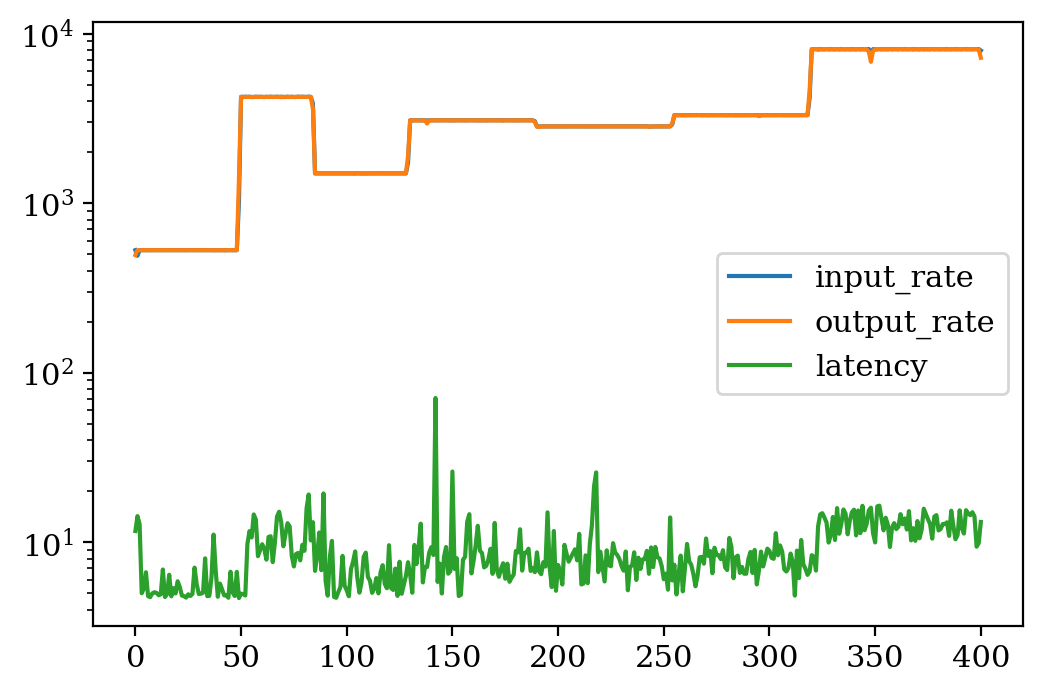

In [16]:
df.loc[:400, ["input_rate", "output_rate", "latency"]].plot(logy=True)

<AxesSubplot:>

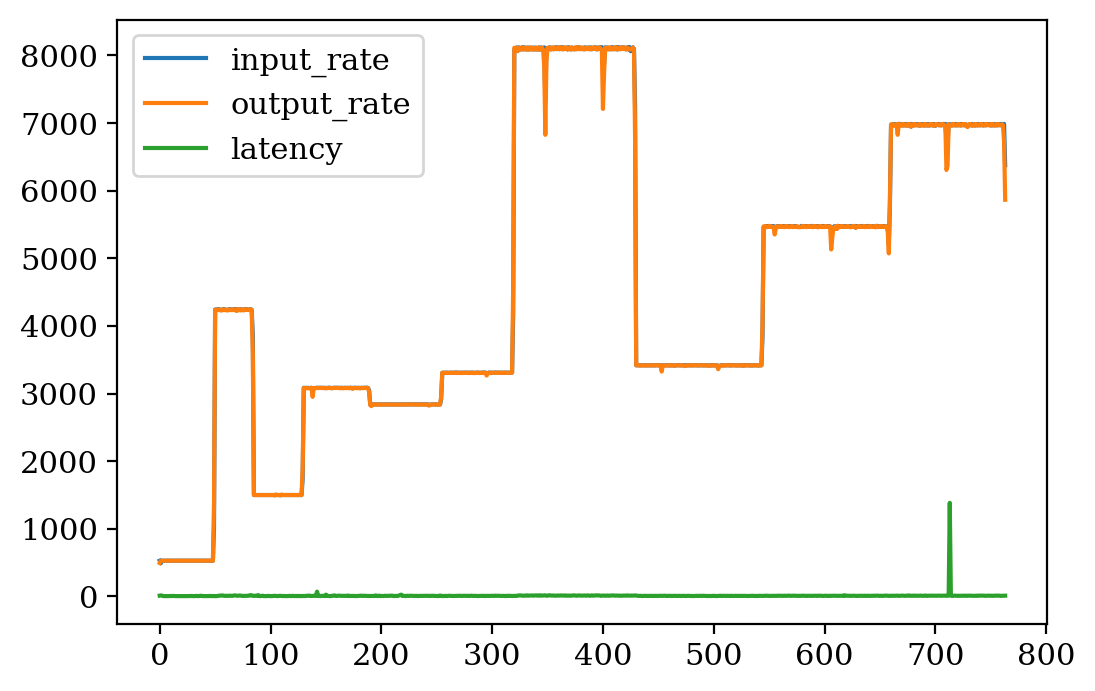

In [14]:
df.iloc[:, 0:3].plot()

In [15]:
df.to_csv("bridge_" + exp_ls + ".csv", sep=',')